In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import tensorflow as tf

from collections import Counter
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Dense, Dropout, Bidirectional, Embedding, BatchNormalization,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2 
from tensorflow.keras import regularizers



In [157]:
train_df = pd.read_csv('arxiv_train.csv')
test_df = pd.read_csv('arxiv_test.csv')

In [158]:
train_df.dropna(subset=['abstract', 'label'], inplace=True)
test_df.dropna(subset=['abstract', 'label'], inplace=True)

In [159]:
import re

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = text.lower()
    return text

train_df['clean_abstract'] = train_df['abstract'].apply(clean_text)
test_df['clean_abstract'] = test_df['abstract'].apply(clean_text)


In [160]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])
num_classes = len(label_encoder.classes_)

### checking if max-words are good

Max length: 432
Mean length: 154.73435
Median length: 150.0


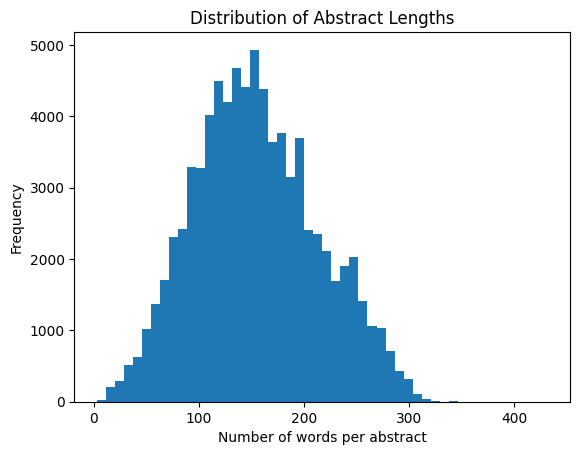

In [161]:
abstract_lengths = train_df['clean_abstract'].apply(lambda x: len(x.split()))

print("Max length:", abstract_lengths.max())
print("Mean length:", abstract_lengths.mean())
print("Median length:", abstract_lengths.median())

import matplotlib.pyplot as plt

plt.hist(abstract_lengths, bins=50)
plt.xlabel("Number of words per abstract")
plt.ylabel("Frequency")
plt.title("Distribution of Abstract Lengths")
plt.show()


In [162]:
all_words = " ".join(train_df['clean_abstract']).split()
word_freq = Counter(all_words)

print("Total unique words:", len(word_freq))
print(word_freq.most_common(10))


Total unique words: 404114
[('the', 889948), ('of', 508097), ('and', 324780), ('a', 302415), ('in', 268166), ('to', 264902), ('we', 196670), ('is', 159279), ('for', 148360), ('that', 123876)]


In [163]:

max_words = 10000  
max_sequence_length = 150 

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['clean_abstract'])

X_train_seq = tokenizer.texts_to_sequences(train_df['clean_abstract'])
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_abstract'])

In [164]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [165]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_sequence_length),
    SimpleRNN(64, activation='tanh', 
              recurrent_regularizer=l2(0.001),
              kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(48, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [166]:
model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [167]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_simple_rnn_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.6,
        patience=1,
        min_lr=0.0001
    )
]

In [168]:
model.summary()


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_17 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [169]:
history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 70ms/step - accuracy: 0.1132 - loss: 2.9396 - val_accuracy: 0.1376 - val_loss: 2.4128 - learning_rate: 3.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.1672 - loss: 2.3923 - val_accuracy: 0.2881 - val_loss: 2.0299 - learning_rate: 3.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.3634 - loss: 1.7536 - val_accuracy: 0.5401 - val_loss: 1.3083 - learning_rate: 3.0000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.5839 - loss: 1.2297 - val_accuracy: 0.6486 - val_loss: 1.0438 - learning_rate: 3.0000e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.6513 - loss: 1.0577 - val_accuracy: 0.6396 - val_loss: 1.1181 - learning_rate: 3.0000e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 71s 71ms/step - accuracy: 0.7015 - loss: 0.9415 - val_accuracy: 0.7046 - val_loss: 0.9343 - learning_rate: 1.8000e-04
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [170]:
test_loss, test_acc = model.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7243 - loss: 0.8969
Test accuracy: 0.7268


In [171]:
y_pred = np.argmax(model.predict(X_test_pad), axis=1)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.90      0.88      0.89      2013
    cond-mat       0.69      0.73      0.71      2058
          cs       0.52      0.56      0.54      1995
        eess       0.60      0.56      0.58      1948
      hep-ph       0.89      0.87      0.88      1990
      hep-th       0.86      0.84      0.85      2019
        math       0.89      0.74      0.81      2042
     physics       0.66      0.41      0.50      1977
    quant-ph       0.69      0.86      0.77      2013
        stat       0.63      0.81      0.71      1945

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.72     20000
weighted avg       0.73      0.73      0.72     20000

Macro F1: 0.7230
Weighted F1: 0.7241


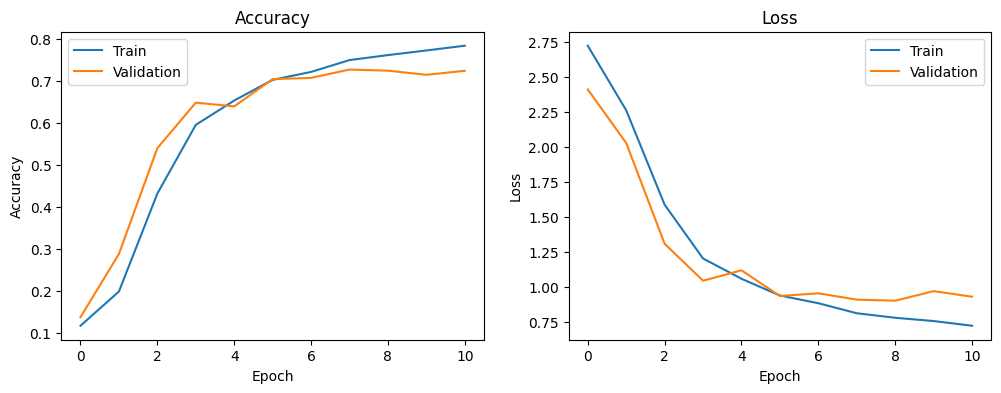

In [172]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# LSTM 

In [173]:
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=32),
    LSTM(64, return_sequences=False), 
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [174]:
model_lstm.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [175]:
callbacks_lstm = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_lstm_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

In [176]:
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1,
    callbacks=callbacks_lstm
)


Epoch 1/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 232s 112ms/step - accuracy: 0.2677 - loss: 1.8392 - val_accuracy: 0.2424 - val_loss: 1.8901
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 267s 133ms/step - accuracy: 0.3815 - loss: 1.5617 - val_accuracy: 0.5994 - val_loss: 1.0404
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 417s 209ms/step - accuracy: 0.6112 - loss: 1.0074 - val_accuracy: 0.6950 - val_loss: 0.8314
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 390s 195ms/step - accuracy: 0.7098 - loss: 0.8078 - val_accuracy: 0.7403 - val_loss: 0.7418
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 402s 201ms/step - accuracy: 0.7742 - loss: 0.6691 - val_accuracy: 0.7650 - val_loss: 0.7115
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 411s 205ms/step - accuracy: 0.8163 - loss: 0.5918 - val_accuracy: 0.7803 - val_loss: 0.6754
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 286s 143ms/step - accuracy: 0.8437 - loss: 0.5272 - val_accuracy: 0.7919 - val_loss: 0.6878
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 202s 101ms/step - ac

In [177]:
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test accuracy: {test_acc_lstm:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 31ms/step - accuracy: 0.7858 - loss: 0.6625
LSTM Test accuracy: 0.7872


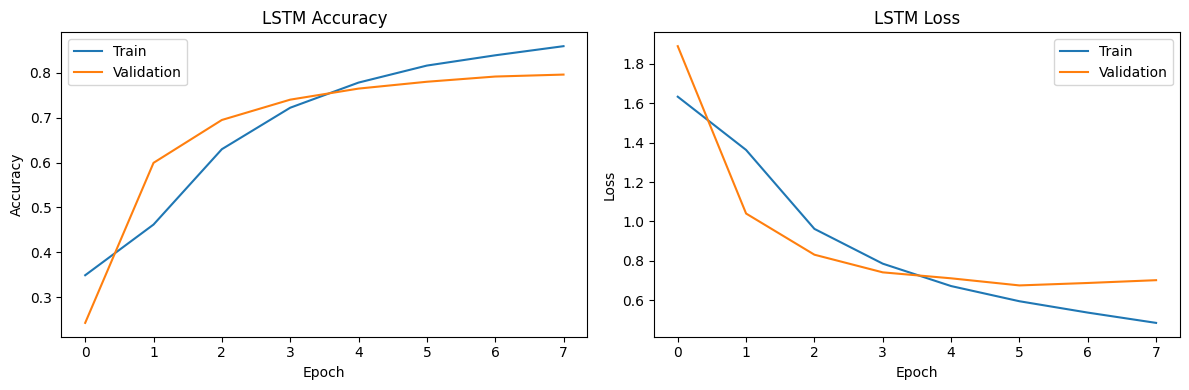

In [178]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['accuracy'], label='Train')
plt.plot(history_lstm.history['val_accuracy'], label='Validation')
plt.title('LSTM Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Train')
plt.plot(history_lstm.history['val_loss'], label='Validation')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# GRU

In [179]:
model_gru = Sequential([
    Embedding(input_dim=max_words, output_dim=64),
    GRU(192 , dropout=0.3, return_sequences=False), 
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_gru = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_gru_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=0.0001
    )
]

history_gru = model_gru.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=callbacks_gru
)

test_loss_gru, test_acc_gru = model_gru.evaluate(X_test_pad, y_test)
print(f"Tuned GRU Test accuracy: {test_acc_gru:.4f}")


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 336s 333ms/step - accuracy: 0.2916 - loss: 1.9147 - val_accuracy: 0.7212 - val_loss: 0.8119 - learning_rate: 5.0000e-04
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 355s 355ms/step - accuracy: 0.7303 - loss: 0.8030 - val_accuracy: 0.7629 - val_loss: 0.7014 - learning_rate: 5.0000e-04
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 354s 354ms/step - accuracy: 0.7844 - loss: 0.6640 - val_accuracy: 0.7766 - val_loss: 0.6597 - learning_rate: 5.0000e-04
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 359s 359ms/step - accuracy: 0.8144 - loss: 0.5864 - val_accuracy: 0.7857 - val_loss: 0.6523 - learning_rate: 5.0000e-04
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 358s 358ms/step - accuracy: 0.8339 - loss: 0.5342 - val_accuracy: 0.7961 - val_loss: 0.6397 - learning_rate: 5.0000e-04
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 366s 366ms/step - accuracy: 0.8497 - loss: 0.4797 - val_accuracy: 0.7920 - val_loss: 0.6366 - learning_rate: 5.0000e-04
Epoch 7/10
1000/1000 ━━━━━━━

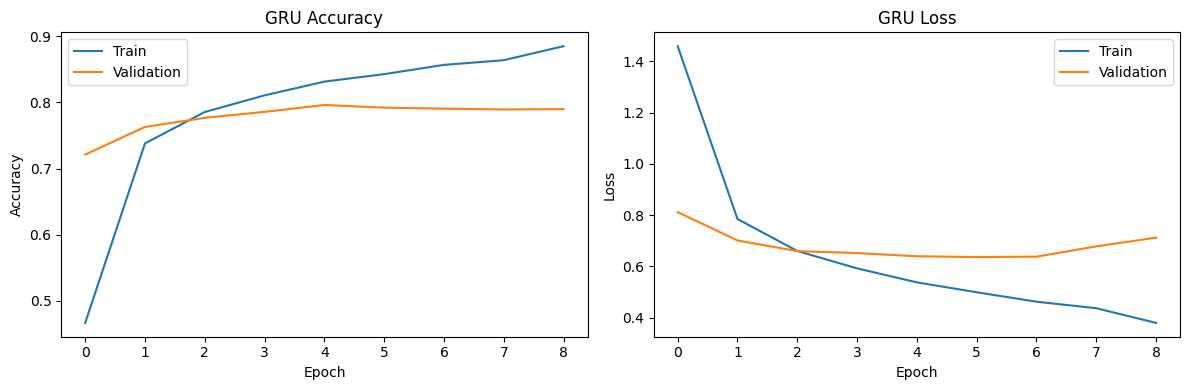

In [180]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train')
plt.plot(history_gru.history['val_accuracy'], label='Validation')
plt.title('GRU Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_gru.history['loss'], label='Train')
plt.plot(history_gru.history['val_loss'], label='Validation')
plt.title('GRU Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# bi RNN

In [181]:
model_bidir_rnn = Sequential([
    Embedding(input_dim=max_words, output_dim=64, input_length=max_sequence_length),
    Bidirectional(SimpleRNN(32, activation='tanh',
                         return_sequences=True,
                         recurrent_regularizer=l2(0.001),
                         kernel_regularizer=l2(0.001))),
    GlobalAveragePooling1D(),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])


C:\Users\Alipc\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [182]:
model_bidir_rnn.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [183]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_simple_rnn_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    )
]

In [184]:
history = model_bidir_rnn.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 59ms/step - accuracy: 0.4062 - loss: 1.8326 - val_accuracy: 0.7245 - val_loss: 0.9703 - learning_rate: 3.0000e-04
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 57s 57ms/step - accuracy: 0.7279 - loss: 0.9689 - val_accuracy: 0.7738 - val_loss: 0.8421 - learning_rate: 3.0000e-04
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 68s 68ms/step - accuracy: 0.7813 - loss: 0.8068 - val_accuracy: 0.7232 - val_loss: 1.0249 - learning_rate: 3.0000e-04
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.8058 - loss: 0.7218 - val_accuracy: 0.7868 - val_loss: 0.7919 - learning_rate: 3.0000e-04
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 81s 81ms/step - accuracy: 0.8208 - loss: 0.6705 - val_accuracy: 0.7676 - val_loss: 0.8182 - learning_rate: 3.0000e-04
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 76s 76ms/step - accuracy: 0.8289 - loss: 0.6305 - val_accuracy: 0.7609 - val_loss: 0.8465 - learning_rate: 3.0000e-04
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━

In [185]:
test_loss, test_acc_bi_rnn = model_bidir_rnn.evaluate(X_test_pad, y_test)
print(f"Test accuracy: {test_acc_bi_rnn:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.7842 - loss: 0.7911
Test accuracy: 0.7853


In [186]:
y_pred = np.argmax(model_bidir_rnn.predict(X_test_pad), axis=1)
print("Classification Report:")
print(metrics.classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Macro F1: {metrics.f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Weighted F1: {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step
Classification Report:
              precision    recall  f1-score   support

    astro-ph       0.96      0.85      0.90      2013
    cond-mat       0.73      0.82      0.77      2058
          cs       0.76      0.58      0.66      1995
        eess       0.61      0.88      0.72      1948
      hep-ph       0.88      0.87      0.88      1990
      hep-th       0.89      0.84      0.87      2019
        math       0.90      0.79      0.84      2042
     physics       0.60      0.63      0.62      1977
    quant-ph       0.84      0.81      0.82      2013
        stat       0.80      0.78      0.79      1945

    accuracy                           0.79     20000
   macro avg       0.80      0.79      0.79     20000
weighted avg       0.80      0.79      0.79     20000

Macro F1: 0.7864
Weighted F1: 0.7870


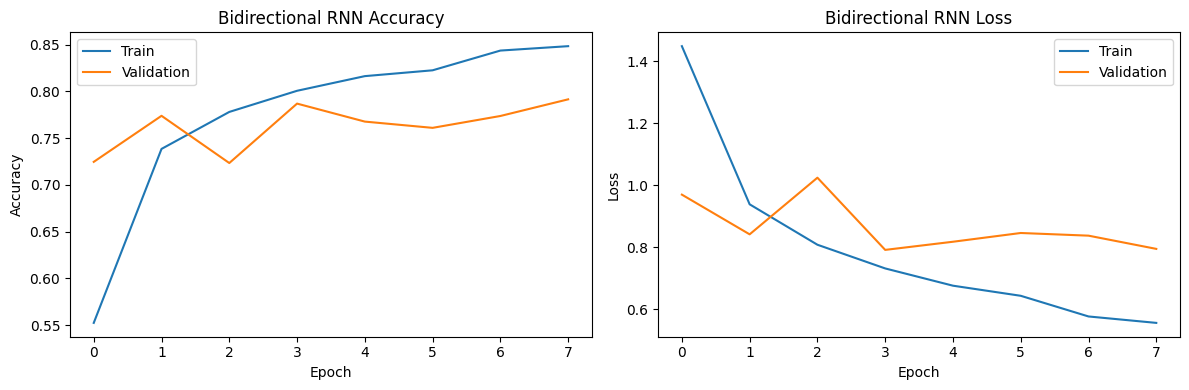

In [187]:
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Bidirectional RNN Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Bidirectional RNN Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


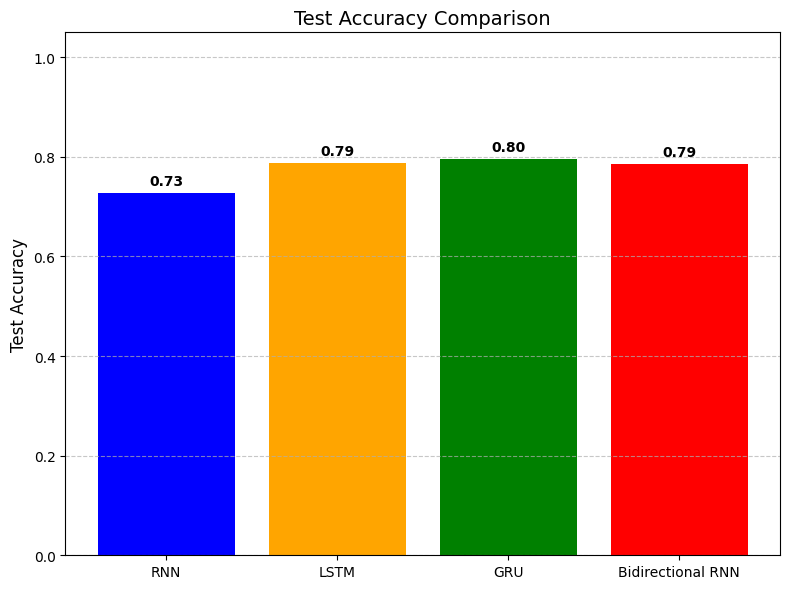

In [188]:
test_accuracies = [test_acc, test_acc_lstm, test_acc_gru, test_acc_bi_rnn]
model_names = ['RNN', 'LSTM', 'GRU', 'Bidirectional RNN']

plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, test_accuracies, color=['blue', 'orange', 'green', 'red'])

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
